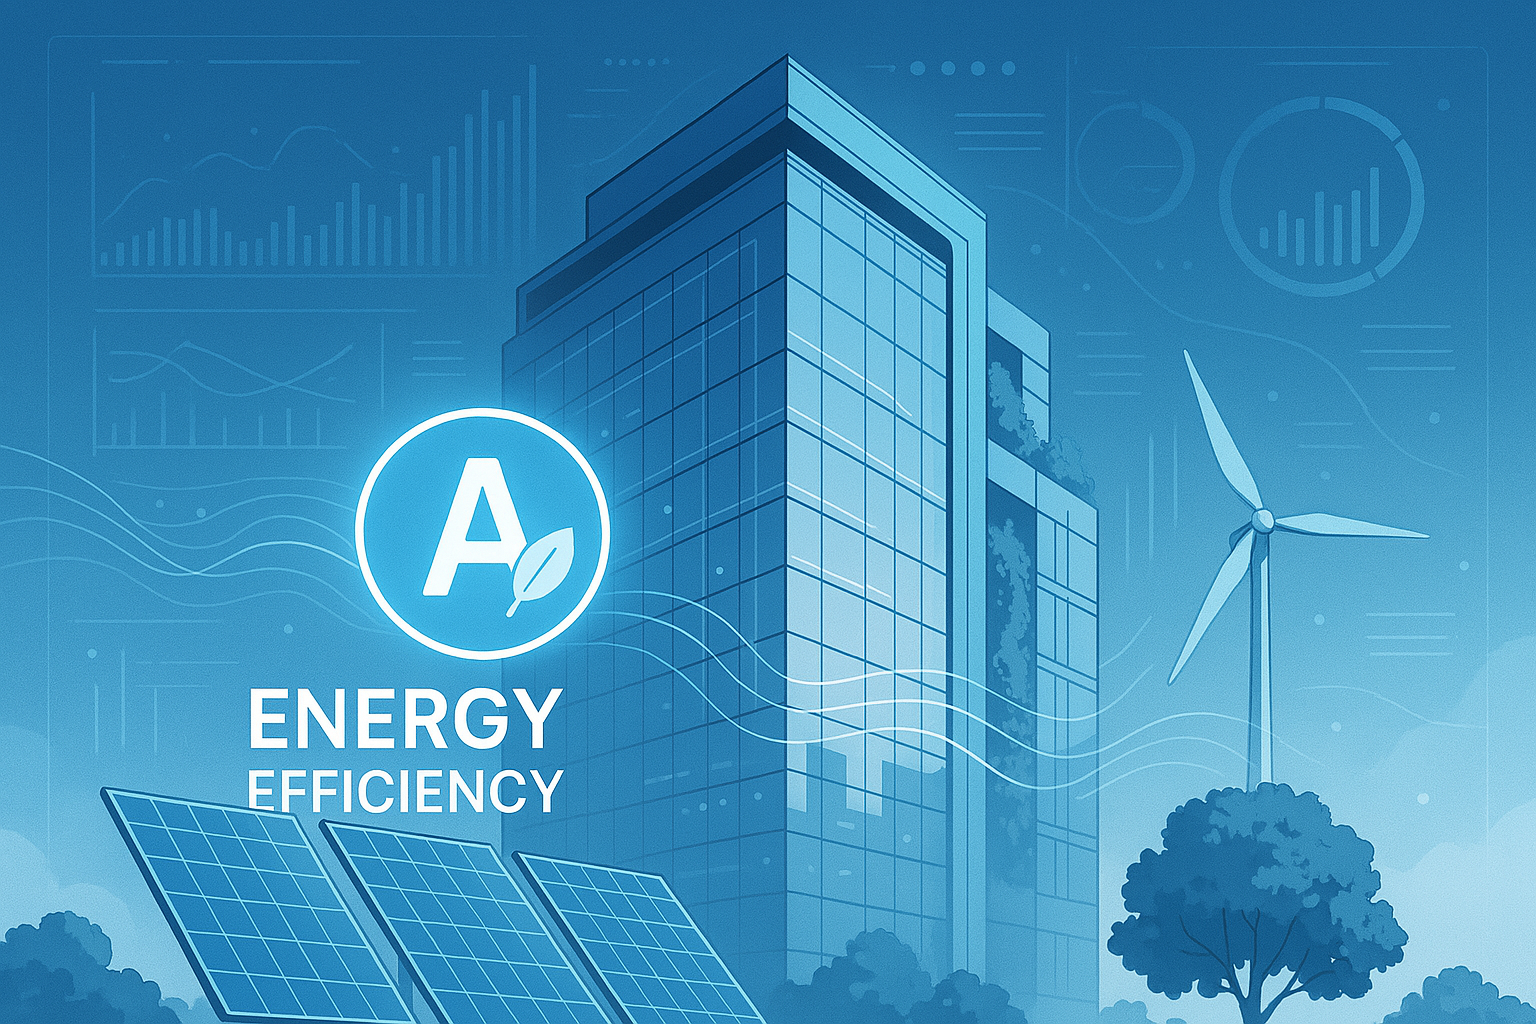

In [1]:
from IPython.display import Image, display
display(Image(filename='../img/Img_No_IA_1.png'))



# MATCHINE LEARNING PROYECT: ENERGETIC EFFICIENCY

by Xián Mosquera Caínzos

## 💼 **BUSSINESS PROBLEM**

## Context
An architecture and engineering consultancy firm wants to offer sustainable design solutions to its clients by minimizing energy consumption in residential and commercial buildings. Energy efficiency is a key concern, especially in regions with strict environmental regulations and rising energy costs.

## Challenge
The firm aims to develop a predictive tool that can estimate the **Heating Load (HL)** and **Cooling Load (CL)** of buildings based on various architectural features such as wall area, roof area, orientation, glazing area, etc. This model would enable architects to evaluate multiple design options quickly and identify the most energy-efficient configuration during the early design phase.

## Objective
Build a machine learning model that predicts the **Heating Load** and/or **Cooling Load** of a building based on its physical parameters. The goal is to reduce the number of design iterations and recommend configurations that require less energy, thus lowering both environmental impact and long-term operating costs.

## Key Questions
- Can we predict the energy demand (HL/CL) of a building based solely on design features?
- Which features have the most impact on heating and cooling requirements?
- How can this model assist designers in making smarter decisions upfront?

#### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## 1. Load Dataset


In [12]:
df = pd.read_csv('../data_sample/energy_efficiency_data.csv')
df.head()

Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  Heating_Load  \
0            2           0.0                          0         15.55   
1            3           0.0                          0         15.55   
2            4           0.0                          0         15.55   
3            5           0.0                          0         15.55   
4            2           0.0                          0         20.84   

   Cooling_Load  
0         21.33  
1         21.33  
2         21.33  
3         21.33  
4         28.28

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [14]:
df.isnull().sum()

Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

In [15]:
df.duplicated().sum()

0

In [16]:
df.describe()

Relative_Compactness  Surface_Area   Wall_Area   Roof_Area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167    671.708333  318.500000  176.604167   
std                0.105777     88.086116   43.626481   45.165950   
min                0.620000    514.500000  245.000000  110.250000   
25%                0.682500    606.375000  294.000000  140.875000   
50%                0.750000    673.750000  318.500000  183.750000   
75%                0.830000    741.125000  343.000000  220.500000   
max                0.980000    808.500000  416.500000  220.500000   

       Overall_Height  Orientation  Glazing_Area  Glazing_Area_Distribution  \
count       768.00000   768.000000    768.000000                  768.00000   
mean          5.25000     3.500000      0.234375                    2.81250   
std           1.75114     1.118763      0.133221                    1.55096   
min           3.50000     2.000000      0.000000                    0.00000   
25%           3.50000     2.750000      0.100000                    1.75000   
50%           5.25000     3.500000      0.250000                    3.00000   
75%           7.00000     4.250000      0.400000                    4.00000   
max           7.00000     5.000000      0.400000                    5.00000   

       Heating_Load  Cooling_Load  
count    768.000000    768.000000  
mean      22.307201     24.587760  
std       10.090196      9.513306  
min        6.010000     10.900000  
25%       12.992500     15.620000  
50%       18.950000     22.080000  
75%       31.667500     33.132500  
max       43.100000     48.030000

Here we have a clean DataFrame without any null value or column, neither any duplicate value, so we don't need to make a prework in order to clean the DataFrame.

## 2. Feature Description




| 🏷️ **Column**                  | 📚 **Description** |
|-------------------------------|---------------------|
| **Relative_Compactness**       | Ratio between the building's volume and its envelope surface area. Higher values indicate more compact designs, often leading to improved energy efficiency. |
| **Surface_Area**               | Total exterior surface area of the building (in m²). |
| **Wall_Area**                  | Total wall surface area of the building (in m²). |
| **Roof_Area**                  | Total roof surface area of the building (in m²). |
| **Overall_Height**             | Height of the building (in meters). Only two values appear: 3.5 and 7.0. |
| **Orientation**                | Cardinal orientation of the building, encoded as:<br> `2 = North`, `3 = East`, `4 = South`, `5 = West`. |
| **Glazing_Area**               | Ratio of window area to the building’s envelope surface area, ranging from `0.0` to `0.4`. |
| **Glazing_Area_Distribution**  | Distribution of the glazing (windows), encoded as:<br> `0 = None`, `1 = Uniform`, `2 = North`, `3 = East`, `4 = South`, `5 = West`. |
| **Heating_Load**               | Amount of energy required for heating (in kWh/m²). Used as a target variable for prediction. |
| **Cooling_Load**               | Amount of energy required for cooling (in kWh/m²). Also used as a target variable. |


## 3. Mini-EDA 

### 3.1 Histograms

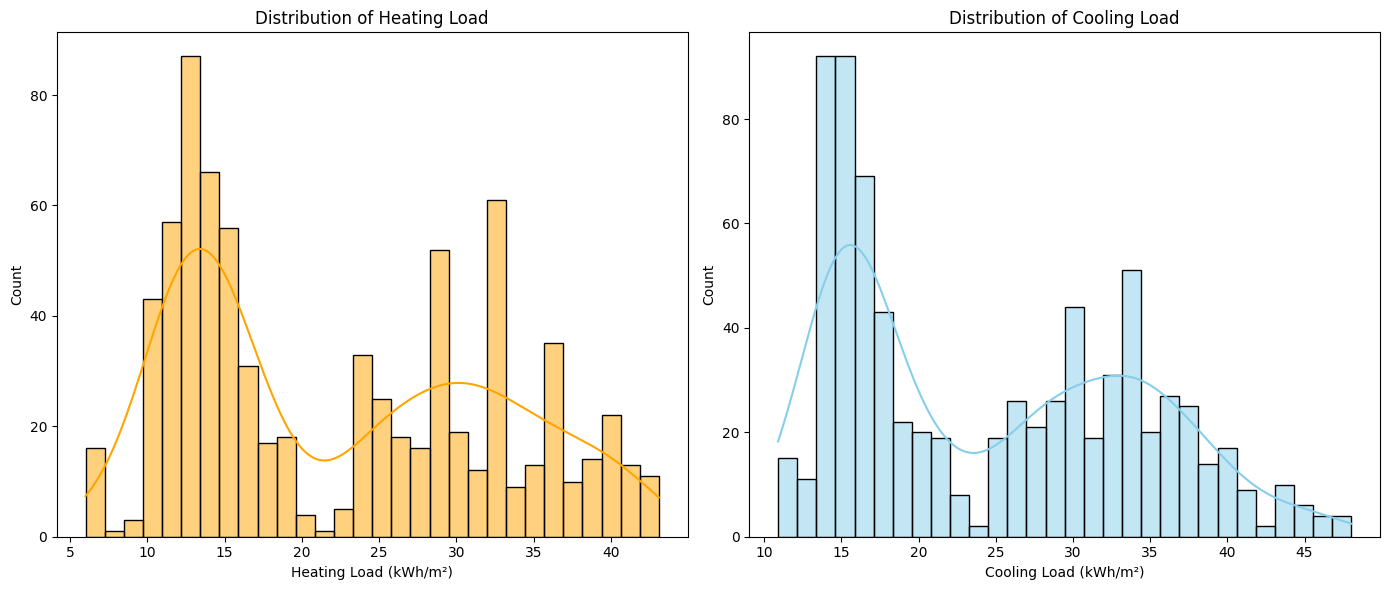

In [17]:
### Chosing size
plt.figure(figsize=(14, 6))

### Histogram for Heating Load
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Heating_Load', bins=30, kde=True, color='orange')
plt.title('Distribution of Heating Load')
plt.xlabel('Heating Load (kWh/m²)')

### Histogram for Cooling Load
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Cooling_Load', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Cooling Load')
plt.xlabel('Cooling Load (kWh/m²)')

### Showing each histogram
plt.tight_layout()
plt.show()


#### What does this tell us?

· Heating Load may require transformation or outlier handling, especially if we use models sensitive to skewness (like linear regression).

· The distributions suggest that predicting Heating Load might be slightly more complex due to its broader variance and skewness.

### 3.2 Heatmap

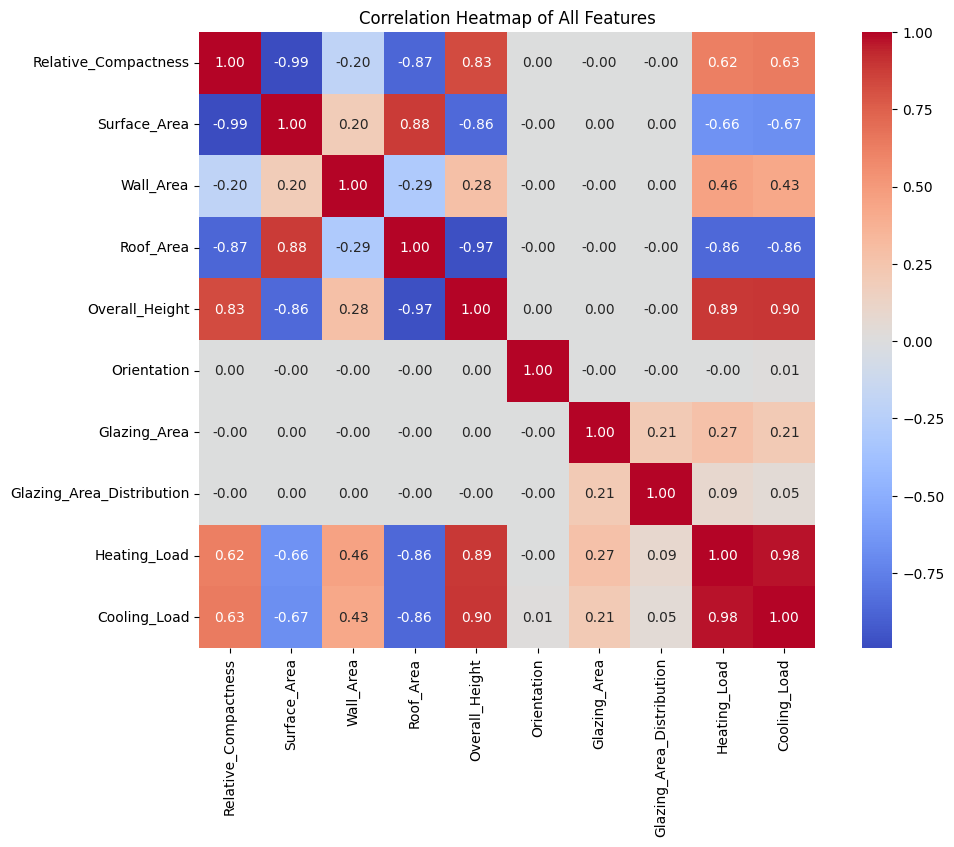

In [18]:
### Calculate de correltation matrix
correlation_matrix = df.corr()

### Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of All Features')
plt.show()


#### What does this tell us?

· Heating_Load and Cooling_Load show a strong positive correlation (~0.90), which makes sense: buildings that require more energy for heating tend to also need more for cooling.

· Overall_Height and Relative_Compactness have a strong negative correlation with each other, and both are strongly correlated (positively and negatively, respectively) with the target variables.

· Surface_Area, Wall_Area, and Roof_Area also show moderate correlations with the energy loads, suggesting they might be relevant features for modeling.

## 4. Select target

In [19]:
### Select features (X) and target (Y)
X = df.drop(['Heating_Load', 'Cooling_Load'], axis=1)
y = df[['Heating_Load', 'Cooling_Load']]

### Divide df in train - test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

Y its a DataFrame with 2 columns, so this let us a multiexit model

## 5. Dir Models

In [20]:
### Lets make a dir with all the models
models = {
    'linear_regression': MultiOutputRegressor(LinearRegression()),
    'random_forest': MultiOutputRegressor(RandomForestRegressor(random_state=42)),
    'knn': MultiOutputRegressor(KNeighborsRegressor()) }

In [21]:
### Check if models exist
os.makedirs('../models', exist_ok=True)

### Save models
for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, f'../models/{name}.pkl')


Now we have created a dir called 'models' wich its going to be used to save the models

## 6. Fit and RMSE

#### Now we are going to fit the models and select wich its the best based on RMSE

In [22]:
# Ruta a la carpeta de modelos
model_path = '../models'

# Diccionario para guardar los resultados
results = {}

# Evaluar cada modelo
for name in ['linear_regression', 'random_forest', 'knn']:
    # Cargar el modelo
    model = joblib.load(f'{model_path}/{name}.pkl')
    
    # Predecir en el conjunto de test
    y_pred = model.predict(X_test)
    
    # Calcular RMSE para cada variable
    rmse_heating = np.sqrt(mean_squared_error(y_test['Heating_Load'], y_pred[:, 0]))
    rmse_cooling = np.sqrt(mean_squared_error(y_test['Cooling_Load'], y_pred[:, 1]))
    
    # Guardar resultados
    results[name] = {
        'RMSE_Heating': rmse_heating,
        'RMSE_Cooling': rmse_cooling
    }

# Mostrar resultados en un DataFrame ordenado
results_df = pd.DataFrame(results).T.sort_values(by='RMSE_Heating')
results_df

RMSE_Heating  RMSE_Cooling
random_forest          0.490798      1.712920
knn                    2.210241      2.074323
linear_regression      3.025424      3.145382

#### What does this tell us? 

We can easily see that RandomForest it's better than KNN and the classic linear regression, so we are going to try to find the best hyperparameters to make our RandomForest 
the best prediction model.

## 7. Optimizing our model

##### With the recent information we are going to select our model... 🥁🥁🥁 RANDOMFOREST 

Now we are going to try to optimize our model as much as possible. To do this, we will tune the hyperparameters.

### 🌲 Random Forest Hyperparameter Description

| Hyperparameter            | Description |
|---------------------------|-------------|
| `n_estimators`            | Number of trees in the forest. More trees can improve performance but also increase training time. |
| `max_depth`               | Maximum depth of each tree. Limiting depth helps prevent overfitting. If `None`, nodes are expanded until all leaves are pure. |
| `min_samples_split`       | Minimum number of samples required to split an internal node. Higher values reduce model complexity. |
| `min_samples_leaf`        | Minimum number of samples required to be at a leaf node. Helps control overfitting by forcing leaves to have more data. |


In [23]:
### Define the base model
base_model = RandomForestRegressor(random_state= 42)

### Package it for multiple output
multi_output = MultiOutputRegressor(base_model)

### Defining grid for hyperparameters
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]}

### GridSearch with cross validation 
grid_search = GridSearchCV(
    estimator=multi_output,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [None, 10, 20, 30],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [24]:
### Best model
best_rf_model = grid_search.best_estimator_

### Test evaluation
y_pred = best_rf_model.predict(X_test)
rmse_heating = np.sqrt(mean_squared_error(y_test['Heating_Load'], y_pred[:, 0]))
rmse_cooling = np.sqrt(mean_squared_error(y_test['Cooling_Load'], y_pred[:, 1]))

print('Best Parameters:', grid_search.best_params_)
print(f'RMSE Heating: {rmse_heating:.4f}')
print(f'RMSE Cooling: {rmse_cooling:.4f}')

Best Parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
RMSE Heating: 0.4908
RMSE Cooling: 1.7129


In [25]:
### Save the best model to the models folder
joblib.dump(best_rf_model, '../models/random_forest_optimized.pkl')
print('Best model saved as random_forest_optimized.pkl')

Best model saved as random_forest_optimized.pkl


### What does this tell us?

RMSE optimized and RMSE base are the same so we didn't need to adjust more

## 8. How to use our model

In [27]:
### Select the optimized model
model = joblib.load('../models/random_forest_optimized.pkl')

### Create an exaple and save it as a DataSet
example = pd.DataFrame([{
    'Relative_Compactness': 0.75,
    'Surface_Area': 650.0,
    'Wall_Area': 300.0,
    'Roof_Area': 150.0,
    'Overall_Height': 3.5,
    'Orientation': 2,
    'Glazing_Area': 0.25,
    'Glazing_Area_Distribution': 1 }])

### Prediction
prediction = model.predict(example)

### Show results
print(f'Predicted Heating Load: {prediction[0][0]:.2f} kWh/m²')
print(f'Predicted Cooling Load: {prediction[0][1]:.2f} kWh/m²')

Predicted Heating Load: 20.35 kWh/m²
Predicted Cooling Load: 19.54 kWh/m²


## 9. Comparing real values VS predicted values

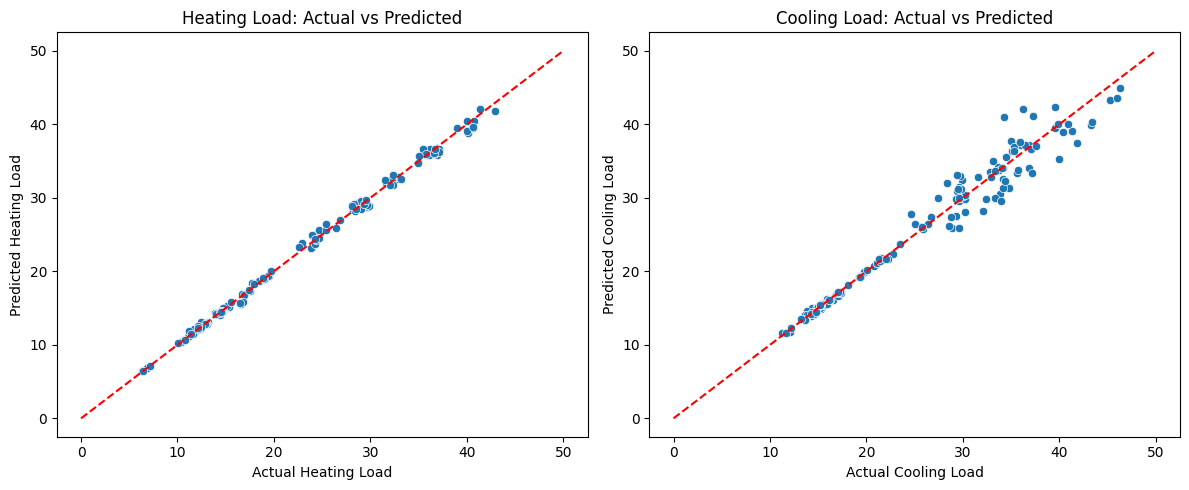

In [ ]:

plt.figure(figsize=(12, 5))

### Heating Load
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test['Heating_Load'], y=y_pred[:, 0])
plt.plot([0, 50], [0, 50], 'r--')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title('Heating Load: Actual vs Predicted')

### Cooling Load
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test['Cooling_Load'], y=y_pred[:, 1])
plt.plot([0, 50], [0, 50], 'r--')
plt.xlabel('Actual Cooling Load')
plt.ylabel('Predicted Cooling Load')
plt.title('Cooling Load: Actual vs Predicted')

plt.tight_layout()
plt.show()


### What does this tell us?


### 📉 Actual vs Predicted: Analysis

The scatter plots above compare the actual values with the predictions made by the model for both target variables:

- For **Heating Load**, the data points align closely with the red diagonal line (which represents perfect predictions). This indicates that the model is performing **very accurately** on this variable.
- For **Cooling Load**, we also observe a good overall alignment, although there's **slightly more dispersion**, especially in higher values. This suggests the model may have **some difficulty predicting extreme cases**.

Overall, the plots confirm that the model has a **strong fit** and is capable of reliably predicting a building's thermal energy requirements.


## 10. 📌 Final Conclusions

- The optimized Random Forest achieved excellent RMSE values:
  - Heating Load: 0.49 kWh/m²
  - Cooling Load: 1.71 kWh/m²
- Feature importance analysis suggests that Relative Compactness and Overall Height are the most influential.
- The model can now be used by architects or engineers to simulate energy performance of building designs.
